# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
# TODO: Install any packages that you might need
!pip install tensorflow boto3 sagemaker smdebug


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 35.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 36.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 8.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# TODO: Import any packages that you might need
import os
import json
import boto3
from tqdm import tqdm
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs,ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from PIL import Image
import io
from IPython import display
import matplotlib.pyplot as plt
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs
import smdebug
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor
from smdebug.trials import create_trial



[2023-07-10 00:26:09.278 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:23244 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]

  0%|          | 0/2666 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [16:09<00:00,  1.93it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [5]:

def analyze_dataset(root_folder='train_data'):
    classes = [folder for folder in os.listdir(root_folder)]
    class_counts = {}

    for class_ in classes:
        class_folder = os.path.join(root_folder, class_)
        num_samples = len(os.listdir(class_folder))
        class_counts[class_] = num_samples
        print(f"Class {class_} has {num_samples} samples.")

    total_samples = sum(class_counts.values())
    print(f"Total samples in dataset: {total_samples}")

    for class_, num_samples in class_counts.items():
        print(f"Percentage of samples in class {class_}: {num_samples / total_samples * 100:.2f}%")

analyze_dataset()

Class 4 has 2373 samples.
Class 2 has 2299 samples.
Class 1 has 1228 samples.
Class 5 has 1875 samples.
Class 3 has 2666 samples.
Total samples in dataset: 10441
Percentage of samples in class 4: 22.73%
Percentage of samples in class 2: 22.02%
Percentage of samples in class 1: 11.76%
Percentage of samples in class 5: 17.96%
Percentage of samples in class 3: 25.53%


In [8]:
import random
import shutil
import numpy as np


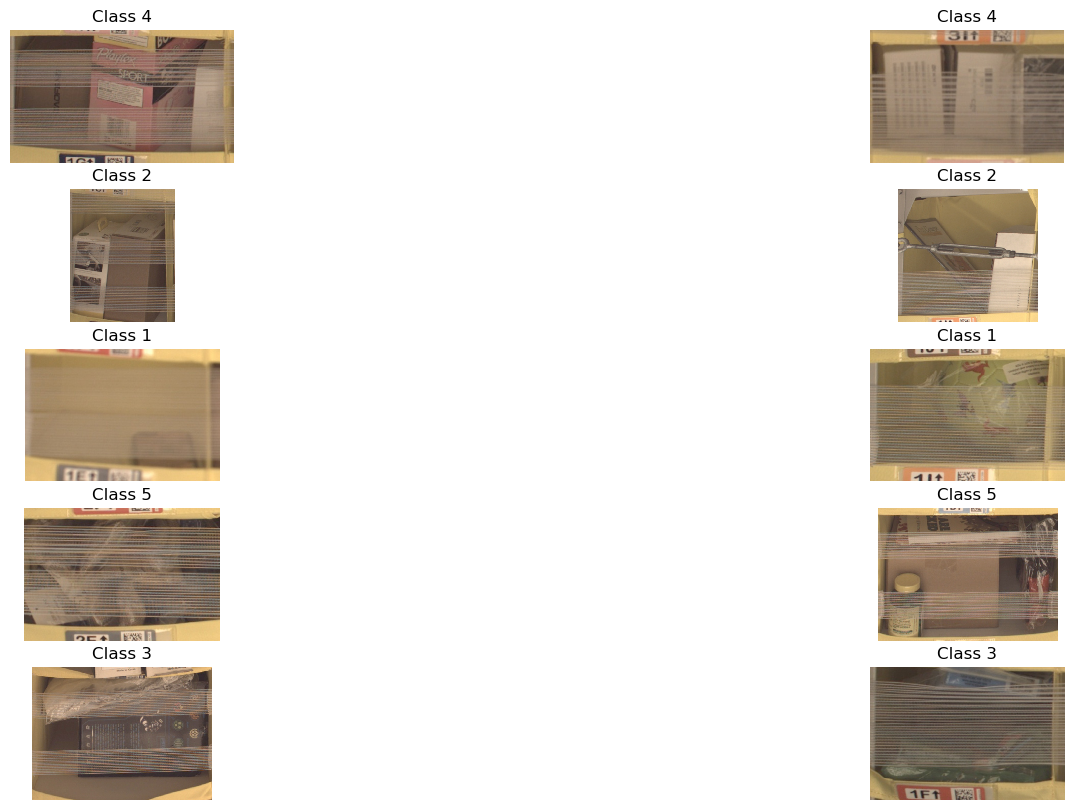

In [7]:

def display_random_images(root_folder='train_data', num_images=2):
    classes = [folder for folder in os.listdir(root_folder)]
    
    fig = plt.figure(figsize=(20, 10))

    for i, class_ in enumerate(classes):
        class_folder = os.path.join(root_folder, class_)
        image_files = os.listdir(class_folder)
        random_images = random.sample(image_files, num_images)

        for j, image_file in enumerate(random_images):
            image_path = os.path.join(class_folder, image_file)
            image = Image.open(image_path)

            ax = fig.add_subplot(len(classes), num_images, i * num_images + j + 1)
            ax.imshow(image)
            ax.set_title(f"Class {class_}")
            ax.axis('off')

    plt.show()

display_random_images()

In [9]:
def create_data_splits(source_folder='train_data', target_folder='binDataset', train_size=0.7, valid_size=0.15):
    # Ensure the target directory exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    classes = [folder for folder in os.listdir(source_folder)]
    for class_ in classes:
        print(f"Processing class: {class_}")

        # Create target subdirectories
        os.makedirs(os.path.join(target_folder, 'train', class_), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'valid', class_), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'test', class_), exist_ok=True)

        # List all images in this class
        image_files = os.listdir(os.path.join(source_folder, class_))

        # Shuffle and split data
        np.random.shuffle(image_files)
        train, valid, test = np.split(image_files, [int(train_size*len(image_files)), int((train_size+valid_size)*len(image_files))])

        # Copy files into respective splits
        for image_file in train:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'train', class_, image_file))
        for image_file in valid:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'valid', class_, image_file))
        for image_file in test:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'test', class_, image_file))

create_data_splits()

Processing class: 4
Processing class: 2
Processing class: 1
Processing class: 5
Processing class: 3


In [12]:
#TODO: Upload the data to AWS S3
s3_bucket = 'ml-data-udacity-learning/'
!aws s3 cp --recursive binDataset s3://$s3_bucket/binDataset


upload: binDataset/test/1/00048.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00048.jpg
upload: binDataset/test/1/00024.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00024.jpg
upload: binDataset/test/1/00710.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00710.jpg
upload: binDataset/test/1/01666.jpg to s3://ml-data-udacity-learning//binDataset/test/1/01666.jpg
upload: binDataset/test/1/00743.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00743.jpg
upload: binDataset/test/1/01308.jpg to s3://ml-data-udacity-learning//binDataset/test/1/01308.jpg
upload: binDataset/test/1/00650.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00650.jpg
upload: binDataset/test/1/00320.jpg to s3://ml-data-udacity-learning//binDataset/test/1/00320.jpg
upload: binDataset/test/1/01673.jpg to s3://ml-data-udacity-learning//binDataset/test/1/01673.jpg
upload: binDataset/test/1/01320.jpg to s3://ml-data-udacity-learning//binDataset/test/1/01320.jpg
upload: binDataset/t

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [57]:
#TODO: Declare your model training hyperparameter.
hyper_param= {
    'batch_size': '64',
    'learning_rate': '0.001',
    'epochs': '1'
}

In [15]:
session = sagemaker.Session()
bucket = session.default_bucket()

In [16]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_CHANNEL_TRAIN']= "s3://ml-data-udacity-learning//binDataset/"


In [19]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [62]:
#TODO: Create your training estimator

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    instance_count=1, 
    instance_type="ml.g4dn.xlarge",
    entry_point="train.py",
    framework_version="2.6",  
    py_version='py38',        
    hyperparameters=hyper_param,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)


In [64]:
# TODO: Fit your estimator
estimator.fit({"train":  "s3://ml-data-udacity-learning//binDataset/"}, wait=True)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-07-10-18-09-40-463


Using provided s3_resource
2023-07-10 18:09:40 Starting - Starting the training job...
2023-07-10 18:09:55 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-07-10 18:11:08 Downloading - Downloading input data...
2023-07-10 18:11:33 Training - Downloading the training image........................
2023-07-10 18:15:34 Training - Training image download completed. Training in progress..2023-07-10 18:15:41.139123: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-07-10 18:15:41.139358: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 7
2023-07-10 18:15:41.139401: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2023-07-10 18:15:41.139413

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [28]:
# TODO: Display the profiler output
debugging_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
debugging_path

's3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-03-15-11-481/rule-output'

In [29]:
! aws s3 ls {debugging_path} --recursive


2023-07-10 04:40:36     329730 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-07-10 04:40:36     171100 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-07-10 04:40:32        192 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-07-10 04:40:32        200 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-07-10 04:40:32        126 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-07-10 04:40:32        127 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-07-10 04:40:32        199 tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profil

In [30]:
! aws s3 cp {debugging_path} ./ --recursive


download: s3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-03-15-11-481/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-ap-southeast-2-4294482669

In [31]:
from IPython.display import display, HTML


In [37]:
# Open and read the file
with open('./ProfilerReport/profiler-output/profiler-report.html', 'r') as f:
    html_string = f.read()

# Display the HTML string in the notebook
display(HTML(html_string))

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [39]:
from sagemaker.tensorflow import TensorFlowModel


In [67]:
estimator.model_data

's3://sagemaker-ap-southeast-2-429448266923/tensorflow-training-2023-07-10-18-09-40-463/output/model.tar.gz'

In [76]:
# TODO: Deploy your model to an endpoint
model = TensorFlowModel(model_data=estimator.model_data, 
                        role=sagemaker.get_execution_role(), 
                        framework_version='2.6', 
                        entry_point='inference.py',
                        sagemaker_session=session)






In [77]:
# TODO: Run an prediction on the endpoint
predictor = model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2023-07-10-18-59-24-176
INFO:sagemaker:Creating endpoint-config with name tensorflow-inference-2023-07-10-18-59-24-905
INFO:sagemaker:Creating endpoint with name tensorflow-inference-2023-07-10-18-59-24-905


--------------------------------------------------------*

UnexpectedStatusException: Error hosting endpoint tensorflow-inference-2023-07-10-18-59-24-905: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

In [74]:

# Load image
image_path = "./binDataset/test/1/00024.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))
img_array = np.array(img) / 255.0

# Convert image array to list and build JSON payload
payload = json.dumps({"url": img_array.tolist()})

# Perform prediction
response = predictor.predict(payload)

# Print prediction result
print(response)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary and could not load the entire response body. See https://ap-southeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/tensorflow-inference-2023-07-10-18-40-37-615 in account 429448266923 for more information.

In [ ]:
# TODO: Train your model on Multiple Instances